In [1]:
import CairoMakie as CM
using Comrade
using Plots
using Pyehtim

Welcome to eht-imaging! v 1.2.8 



In [2]:
obseht = ehtim.obsdata.load_uvfits(joinpath("data", "SR1_M87_2017_096_lo_hops_netcal_StokesI.uvfits"))
obs = Pyehtim.scan_average(obseht.flag_uvdist(uv_min=0.1e9))

Loading uvfits:  data/SR1_M87_2017_096_lo_hops_netcal_StokesI.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!
U-V flagged 911/8645 visibilities


[ Info: Before homogenizing we have 25 unique times
[ Info: After homogenizing we have 25 unique times


Python: <ehtim.obsdata.Obsdata object at 0x3128607f0>

In [3]:
vis    = extract_table(obs, Visibilities()) ## complex visibilites
amp    = extract_table(obs, VisibilityAmplitudes()) ## visibility amplitudes
cphase = extract_table(obs, ClosurePhases(; snrcut=1.0)) ## extract minimal set of closure phases
lcamp  = extract_table(obs, LogClosureAmplitudes(; snrcut=1.0)) ## extract minimal set of log-closure amplitudes

Updated self.amp: no averaging
Updated self.amp: avg_time 0.000000 s

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

updated self.lcamp: no averaging
updated self.logcamp: avg_time 0.000000 s



/Users/dominicchang/.julia/environments/v1.10/.CondaPkg/env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/dominicchang/.julia/environments/v1.10/.CondaPkg/env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/dominicchang/.julia/environments/v1.10/.CondaPkg/env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/dominicchang/.julia/environments/v1.10/.CondaPkg/env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


EHTObservationTable{Comrade.EHTLogClosureAmplitudeDatum{:I}}
  source:      M87
  mjd:         57849
  bandwidth:   1.856e9
  sites:       [:AA, :AP, :AZ, :JC, :LM, :PV, :SM]
  nsamples:    116

In [4]:
ac = arrayconfig(vis)

EHTArrayConfiguration:
  source:      M87
  mjd:         57849
  frequencies: [2.27070703125e11]
  bandwidth:   1.856e9
  sites:       [:AA, :AP, :AZ, :JC, :LM, :PV, :SM]
  nsamples:    242

In [5]:
typeof(ac)

Comrade.EHTArrayConfiguration{Comrade.EHTArrayBaselineDatum{Float64, Tuple{CirBasis, CirBasis}, Float64}, Float64, TypedTables.Table{@NamedTuple{sites::Symbol, X::Float64, Y::Float64, Z::Float64, SEFD1::Float64, SEFD2::Float64, fr_parallactic::Float64, fr_elevation::Float64, fr_offset::Float64}, 1, @NamedTuple{sites::Vector{Symbol}, X::Vector{Float64}, Y::Vector{Float64}, Z::Vector{Float64}, SEFD1::Vector{Float64}, SEFD2::Vector{Float64}, fr_parallactic::Vector{Float64}, fr_elevation::Vector{Float64}, fr_offset::Vector{Float64}}}, TypedTables.Table{@NamedTuple{start::Float64, stop::Float64}, 1, @NamedTuple{start::Vector{Float64}, stop::Vector{Float64}}}, StructArrays.StructVector{Comrade.EHTArrayBaselineDatum{Float64, Tuple{CirBasis, CirBasis}, Float64}, @NamedTuple{U::Vector{Float64}, V::Vector{Float64}, Ti::Vector{Float64}, Fr::Vector{Float64}, sites::Vector{Tuple{Symbol, Symbol}}, polbasis::Vector{Tuple{CirBasis, CirBasis}}, elevation::StructArrays.StructVector{Tuple{Float64, Float6

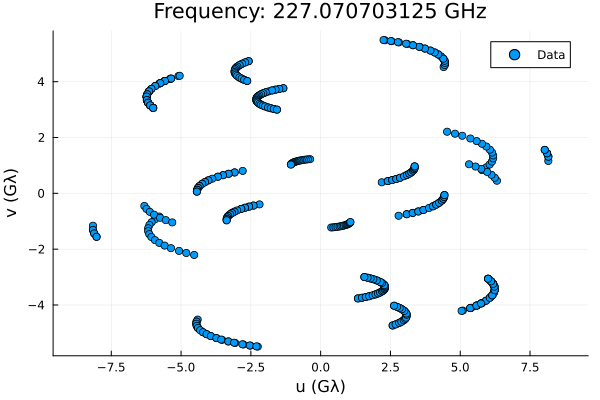

In [6]:
plot(ac)

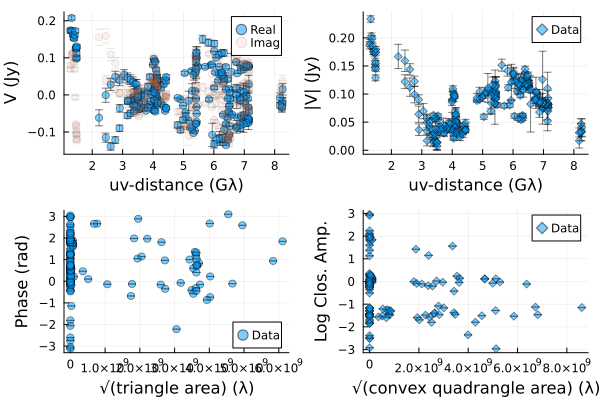

In [7]:
l = @layout [a b; c d]
pv = plot(vis);
pa = plot(amp);
pcp = plot(cphase);
plc = plot(lcamp);
plot(pv, pa, pcp, plc; layout=l)

In [8]:
vis.config.datatable.U

242-element Vector{Float64}:
 -4.405690154666661e9
 -4.444299918222218e9
  1.337045162666665e9
 -1.336260540444443e9
  4.445088654222218e9
  5.781345607111105e9
  1.4806382151111097e9
 -4.455366328888884e9
 -1.4798758791111097e9
  4.456123861333328e9
  5.936013027555549e9
 -4.438811278222218e9
  1.615060401777776e9
  ⋮
  2.6322108302222195e9
  5.999288348444438e9
  1.565423818666665e9
  5.999780252444438e9
 -2.6327225742222195e9
  3.3670615039999967e9
  3.367077162666663e9
  4.433867007999995e9
 -1.5659301759999983e9
  4.433851406222218e9
  1.0667900266666656e9
 -5.999801315555549e9

In [9]:
using Comrade
using Chain
using Distributions

_pd = product_distribution
function _model_prior(param, prior)
    dist_list = map(x-> if param[x] > 1 _pd([prior[x] for _ in 1:param[x]]) else prior[x] end, keys(param))
    return NamedTuple{keys(param)}(dist_list)
end

# Helper functions for μas units
shiftedμas(model, x, y) = shifted(model, μas2rad(x), μas2rad(y))
smoothedμas(model, width) = smoothed(model, μas2rad(width))
stretchedμas(model, rx, ry) = stretched(model, μas2rad(rx), μas2rad(ry))

const PRIOR = (
    rg = Uniform(1.0, 10.0),# Radial size of Gaussians
    τg = Uniform(0.01, 1),# Ratio of Elliptical Gaussian major axis with respect to minor axis
    ξg = Uniform(0, π),# Angular position of Elliptical Gaussian major axis
    xg = Uniform(-50.0, 50.0),# Gaussian horizontal displacement with respect to primary
    yg = Uniform(-50.0, 50.0),# Gaussian vertical displacement with respect to primary
    fg = Uniform(0.501, 1),# Flux ratio between Gaussians (Forces ordering based on flux)
)

#=
    Other
=#
function Circular_Gaussian(prior)
    param_count = (rg=1,)
    cir_gauss(θ,p) = begin
        (;rg) = θ 
         stretchedμas(Gaussian(), rg, rg)
    end
    return (model=cir_gauss, prior=_model_prior(param_count, prior))
end

function Elliptical_Gaussian(prior)
    param_count = (rg=1, ξg=1, τg=1)
    ell_gauss(θ,p) =  begin 
        (;rg, ξg, τg) = θ
        @chain Gaussian() begin
            stretchedμas(_, rg, rg*(τg+1))
            rotated(_, ξg)
        end
    end

    return (model=ell_gauss, prior=_model_prior(param_count, prior))
end

function Two_Circular_Gaussians(prior)
    param_count = (rg=2, xg=1, yg=1, fg=1)
    gauss1, _ = Circular_Gaussian(prior)
    gauss2, _ = Circular_Gaussian(prior)

    two_circ_gauss(θ,p) = begin 
        (;rg, xg, yg, fg) = θ
        prm1 = (rg=rg[1],)
        prm2 = (rg=rg[2],)

        fg*gauss1(prm1,p) + (1-fg)*(shiftedμas(gauss2(prm2,p), xg, yg))
    end

    return (model=two_circ_gauss, prior=_model_prior(param_count, prior))
end

function N_Elliptical_Gaussians(prior, n)
    n == 1 && return Elliptical_Gaussian(prior)
    
    param_count = (rg=n, ξg=n, τg=n, xg=(n-1), yg=(n-1), fg=(n-1))
    el_gauss, _ = Elliptical_Gaussian(prior)
    n_m_1_el_gauss, _ = N_Elliptical_Gaussians(prior, n-1)

    n_el_gauss(θ,p) = begin
        (;rg, ξg, τg, xg, yg, fg) = θ 
        prm = (rg=rg[1], ξg=ξg[1], τg=τg[1])
        prm2 = n > 2 ? (rg=rg[2:end], ξg=ξg[2:end], τg=τg[2:end], xg=xg[2:end], yg=yg[2:end], fg=fg[2:end]) : 
            (rg=rg[2], ξg=ξg[2], τg=τg[2])

        fg[1]*el_gauss(prm,p) + (1-fg[1])*shiftedμas(n_m_1_el_gauss(prm2,p), xg[1], yg[1])
    end

    return (model=n_el_gauss, prior=_model_prior(param_count, prior))
end


N_Elliptical_Gaussians (generic function with 1 method)

In [10]:
model, prior= N_Elliptical_Gaussians(PRIOR, 5)

(model = var"#n_el_gauss#13"{Int64, var"#n_el_gauss#13"{Int64, var"#n_el_gauss#13"{Int64, var"#n_el_gauss#13"{Int64, var"#n_el_gauss#13"{Int64, var"#n_el_gauss#13"{Int64, var"#ell_gauss#11", var"#ell_gauss#11"}, var"#ell_gauss#11"}, var"#ell_gauss#11"}, var"#ell_gauss#11"}, var"#ell_gauss#11"}, var"#ell_gauss#11"}(7, var"#n_el_gauss#13"{Int64, var"#n_el_gauss#13"{Int64, var"#n_el_gauss#13"{Int64, var"#n_el_gauss#13"{Int64, var"#n_el_gauss#13"{Int64, var"#ell_gauss#11", var"#ell_gauss#11"}, var"#ell_gauss#11"}, var"#ell_gauss#11"}, var"#ell_gauss#11"}, var"#ell_gauss#11"}(6, var"#n_el_gauss#13"{Int64, var"#n_el_gauss#13"{Int64, var"#n_el_gauss#13"{Int64, var"#n_el_gauss#13"{Int64, var"#ell_gauss#11", var"#ell_gauss#11"}, var"#ell_gauss#11"}, var"#ell_gauss#11"}, var"#ell_gauss#11"}(5, var"#n_el_gauss#13"{Int64, var"#n_el_gauss#13"{Int64, var"#n_el_gauss#13"{Int64, var"#ell_gauss#11", var"#ell_gauss#11"}, var"#ell_gauss#11"}, var"#ell_gauss#11"}(4, var"#n_el_gauss#13"{Int64, var"#n_el_ga

In [11]:
using Distributions, VLBIImagePriors
skym = SkyModel(model, prior, imagepixels(μas2rad(200.0), μas2rad(200.0), 128, 128))
post = VLBIPosterior(skym, lcamp, cphase)
g = imagepixels(μas2rad(180.0), μas2rad(180.0), 256, 256)
fig = imageviz(intensitymap(model(prior_sample(post).sky, nothing), g), colormap=:afmhot, size=(500, 400));
fig

In [12]:
using Optimization
using OptimizationBBO
xopt, sol = comrade_opt(post, BBO_adaptive_de_rand_1_bin_radiuslimited(); maxiters=500_000);

In [13]:
xopt

(sky = (rg = [9.999028295269952, 9.07153561258621, 7.7872809237729514, 5.25232427354603, 2.304756558352623, 2.5391808853517035, 1.0100213869624977], ξg = [0.5903942342469146, 3.1411965890278277, 1.6234900289997916, 1.0346859131843515, 0.7165759874540981, 2.4893312200902202, 2.9563556926791588], τg = [0.8813596365042693, 0.2792734104577368, 0.7009191468239907, 0.4929402087202671, 0.9939408047677609, 0.9921435925928168, 0.04884372584637973], xg = [-32.065087599210244, 44.595039660946526, -38.01134793443849, 18.991050354474282, 23.39706929927698, 32.58343034498155], yg = [5.024328467296655, 47.05708249378904, 13.348686710122017, -14.47803877692494, 11.55226893503091, -6.148295159235488], fg = [0.5815711849366688, 0.5010985210099678, 0.5010663324530351, 0.5010988439679822, 0.5010865445198521, 0.5011204790902126]),)

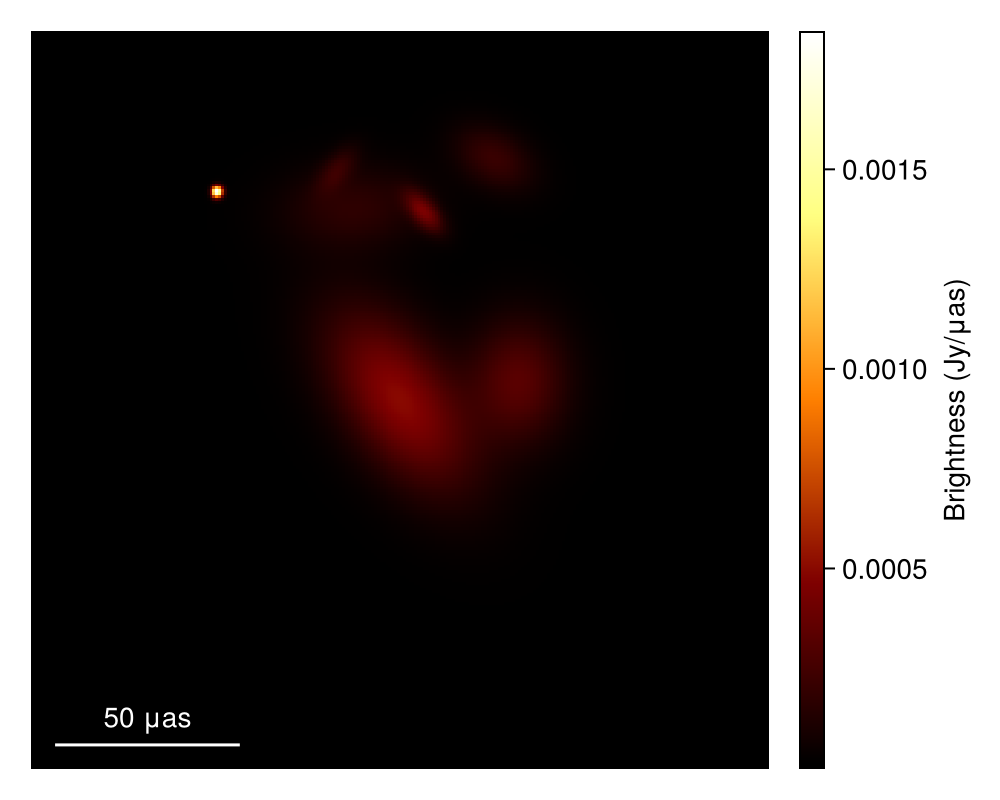

In [15]:
g = imagepixels(μas2rad(200.0), μas2rad(200.0), 256, 256)
fig = imageviz(intensitymap(skymodel(post, xopt), g), colormap=:afmhot, size=(500, 400))

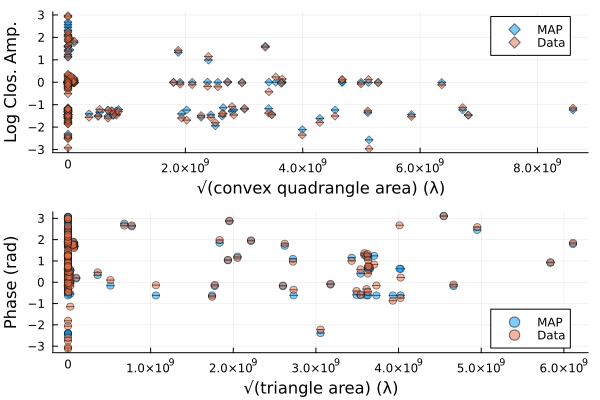

In [16]:
p1 = Plots.plot(simulate_observation(post, xopt; add_thermal_noise=false)[1], label="MAP")
Plots.plot!(p1, lcamp)
p2 = Plots.plot(simulate_observation(post, xopt; add_thermal_noise=false)[2], label="MAP")
Plots.plot!(p2, cphase)
Plots.plot(p1, p2, layout=(2,1))

In [17]:
using Pigeons
pt = pigeons(target=ascube(post), explorer=SliceSampler(), record=[traces, round_trip, log_sum_ratio], n_chains=26, n_rounds=10)

┌ Warning: More than one threads are available, but explore!() loop is not parallelized as inputs.multithreaded == false
└ @ Pigeons ~/.julia/packages/Pigeons/nJHDB/src/pt/checks.jl:12


───────────────────────────────────────────────────────────────────────────────────────
  scans     restarts      Λ      log(Z₁/Z₀)   min(α)     mean(α)    min(αₑ)   mean(αₑ) 
────────── ────────── ────────── ────────── ────────── ────────── ────────── ──────────
        2          0       13.2  -3.01e+03  3.04e-151      0.471          1          1 
        4          0       5.44  -1.15e+03  1.83e-174      0.782          1          1 
        8          0       6.51       -652   3.96e-48       0.74          1          1 
       16          0       8.64       -174   5.72e-07      0.654          1          1 
       32          0         12      -48.5    0.00512      0.519          1          1 
       64          0       13.6      -18.3      0.117      0.456          1          1 
      128          0       13.4       7.13      0.201      0.462          1          1 
      256          0       13.2       25.8       0.32      0.473          1          1 
      512          1       13.1 

PT(checkpoint = false, ...)

In [19]:
using MCMCChains
samples = Chains(pt)

Chains MCMC chain (32768×40×1 Array{Float64, 3}):

Iterations        = 1:1:32768
Number of chains  = 1
Samples per chain = 32768
parameters        = param_1, param_2, param_3, param_4, param_5, param_6, param_7, param_8, param_9, param_10, param_11, param_12, param_13, param_14, param_15, param_16, param_17, param_18, param_19, param_20, param_21, param_22, param_23, param_24, param_25, param_26, param_27, param_28, param_29, param_30, param_31, param_32, param_33, param_34, param_35, param_36, param_37, param_38, param_39
internals         = log_density

Summary Statistics
  parameters      mean       std      mcse     ess_bulk     ess_tail      rhat ⋯
      Symbol   Float64   Float64   Float64      Float64      Float64   Float64 ⋯

     param_1    0.8950    0.0660    0.0034     426.0415     612.9637    1.0234 ⋯
     param_2    0.6315    0.1374    0.0079     417.6830     359.9266    1.0058 ⋯
     param_3    0.5261    0.1236    0.0074     323.7704     281.3593    1.0319 ⋯
     param_4 

In [20]:
imgs = intensitymap.(skymodel.(Ref(post), sample(chain, 1000)), Ref(g));
imageviz(mean(imgs), colormap=:afmhot)

In [21]:
residual(post, chain[end])